In [223]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import beacon
from tqdm import tqdm
from torchinfo import summary

In [104]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [91]:
def draw_parabola(canvas, origin=None):
    if origin is None:
        origin_x = np.random.randint(0, canvas.shape[1])
        origin_y = np.random.randint(canvas.shape[0]*0.25, canvas.shape[0])
    else:
        origin_x = origin[0]
        origin_y = origin[1]
    
    theta = np.arange(0, 1*np.pi, 0.0001)
    
    min_side = np.minimum(canvas.shape[1], canvas.shape[0])
    radius = np.random.randint(min_side, min_side*3)
    x = origin_x + radius * np.cos(theta)
    y = (origin_y - radius + 1) + radius * np.sin(theta)
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    
    valid_indices = np.where((x >= 0) & (x < canvas.shape[1]) & (y >= 0) & (y < canvas.shape[0]))
    
    x_parabola_coords = x[valid_indices]
    y_parabola_coords = y[valid_indices]
    canvas[y_parabola_coords, x_parabola_coords] = 1
    
    point_r = (x_parabola_coords[0], y_parabola_coords[0])
    point_l = (x_parabola_coords[-1], y_parabola_coords[-1])
    
    return point_r, point_l


def draw_line(canvas, start, angle, max_lit_px=400):
    angle = np.radians(angle)
    
    dx = np.cos(angle)
    dy = np.sin(angle)

    x, y = start
    lit_pixels = 0
    
    while lit_pixels < max_lit_px:
        x_rounded = int(round(x))
        y_rounded = int(round(y))
        
        if 0 <= x_rounded < canvas.shape[1] and 0 <= y_rounded < canvas.shape[0]:
            canvas[y_rounded, x_rounded] = 1
        
        if lit_pixels != 0:
            if x_rounded <= 0:
                dx = abs(dx)
            elif x_rounded >= canvas.shape[1] - 1:
                dx = -abs(dx)
        
        x += dx
        y -= dy
        lit_pixels += 1


def random_remove_points(canvas, n_remove):
    none_zero_indices = canvas.nonzero()
    if none_zero_indices.shape[0] < n_remove:
        return

    if n_remove >= 1:
        random_indices = np.random.choice(none_zero_indices.shape[0], n_remove, replace=False)
    else:
        n = int(n_remove * none_zero_indices.shape[0])
        random_indices = np.random.choice(none_zero_indices.shape[0], n, replace=False)

    for i in random_indices:
        x = none_zero_indices[i][1]
        y = none_zero_indices[i][0]
        canvas[y, x] = 0

        

def add_time_value(canvas, t_start):
    rows, cols = canvas.shape
    canvas = canvas.clone()

    first_row = 0
    
    for row in range(rows-1, -1, -1):
        non_zero_indices = np.where(canvas[row, :] != 0)[0]
        if non_zero_indices.size > 0:
            if first_row is None:
                first_row = row
            time_index = rows - row + t_start

            canvas[row, non_zero_indices] = time_index
    
    return canvas


def add_time_dim(canvas, time_index):
    timed_data = torch.zeros(2, canvas.shape[0], canvas.shape[1])
    nonzero_x = canvas.nonzero()[:, 1]
    nonzero_y = canvas.nonzero()[:, 0]
    time_values = canvas[nonzero_y, nonzero_x].to(torch.int)
    timed_data[time_values, nonzero_y, nonzero_x] = 1
    return timed_data


def generate_binary_noise(*dim, p=0.001, magnitude=1):
    random_tensor = torch.rand(*dim)
    return (random_tensor < p).float() * magnitude

def add_noise(data, p=0.001, magnitude=1):
    return torch.clamp(generate_binary_noise(data.shape, p=p, magnitude=magnitude) + data, 0, 1)


def generate(t_dim, x_dim, y_dim, n_objects=1, n_points=10):
    full_data = torch.zeros(n_objects, 1, x_dim, y_dim)
    noised_full_data = torch.zeros(n_objects, 1, x_dim, y_dim)

    for i in range(n_objects):
        data = torch.zeros(x_dim, y_dim)
        pr, pl = draw_parabola(data)

        angle = np.random.randint(10, 40)
        draw_line(data, pr, angle)
        draw_line(data, pl, angle)
        random_remove_points(data, n_points)
        noised_data = add_noise(data, p=0.01)
        timed_data = add_time_value(data, 100)
        noised_timed_data = add_time_value(noised_data, 100)
        max_value = torch.max(noised_timed_data)
        timed_data /= max_value
        noised_timed_data /= max_value
        #timed_data = add_time_dim(data, t_dim)

        full_data[i, 0] = timed_data
        noised_full_data[i, 0] = noised_timed_data

    return full_data, noised_full_data


def plot3d(data, ax=None):
    if ax is None:
        ax = plt.figure().add_subplot(projection='3d')
    data_np = data.numpy().squeeze()
    y, x = np.nonzero(data_np)
    time_values = data_np[y, x]
    ax.scatter(y, x, time_values, c=time_values)
    ax.set_xlabel('Y')
    ax.set_ylabel('X')
    ax.set_zlabel('Time')
    ax.set_box_aspect(None, zoom=0.85)
    
def plot2d(data):
    plt.imshow(data.squeeze())
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar()

In [92]:
class TorchData:
    def __init__(self, t_dim, x_dim, y_dim, n_remove=10):
        """
        Initiate torch datasets.
        Args:
            t_dim: int, time dimension
            x_dim: int, x dimension
            y_dim: int, y dimension
            n_remove: int, number of points to remove
        """
        self.t_dim = t_dim
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.n_remove = n_remove
        self.data = torch.zeros(self.x_dim, self.y_dim)
        self.noised_data = torch.zeros(self.x_dim, self.y_dim)
        self.timed_data = torch.zeros(self.x_dim, self.y_dim)
        self.noised_timed_data = torch.zeros(self.x_dim, self.y_dim)
        self.generate()
        
    def generate(self):
        """
        Generate datasets.
        """
        pr, pl = draw_parabola(self.data)

        angle = np.random.randint(10, 40)
        draw_line(self.data, pr, angle)
        draw_line(self.data, pl, angle)
        random_remove_points(self.data, self.n_remove)
        self.noised_data = add_noise(self.data, p=0.01, magnitude=1)
        self.timed_data = add_time_value(self.data, 100)
        self.noised_timed_data = add_time_value(self.noised_data, 100)


In [112]:
train_dataset = np.array([TorchData(100, 120, 92, 10) for _ in range(128)])
test_dataset = np.array([TorchData(100, 120, 92, 10) for _ in range(1)])


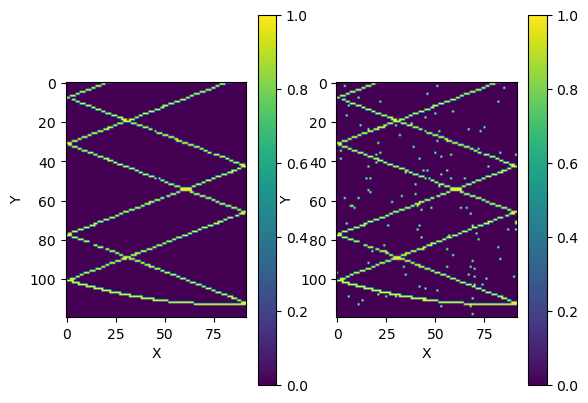

In [113]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot2d(train_dataset[0].data)
ax2 = fig.add_subplot(122)
plot2d(train_dataset[0].noised_data)

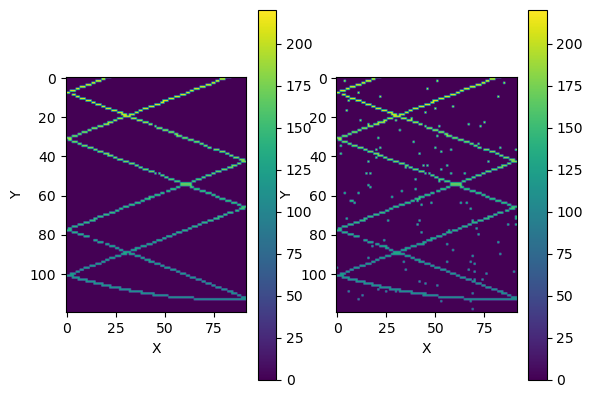

In [114]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot2d(train_dataset[0].timed_data)
ax2 = fig.add_subplot(122)
plot2d(train_dataset[0].noised_timed_data)

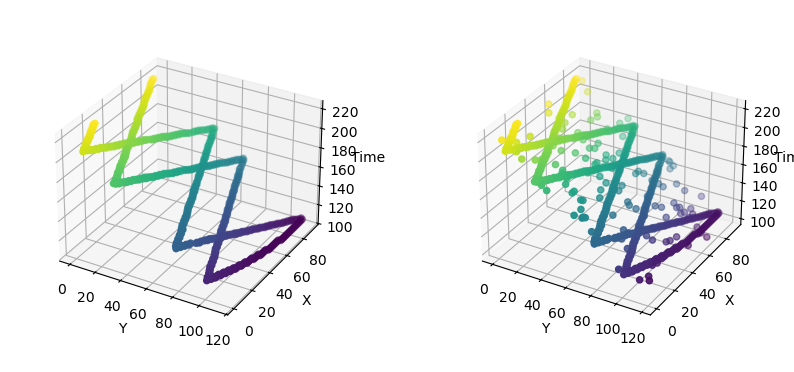

In [115]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
plot3d(train_dataset[0].timed_data, ax1)
ax2 = fig.add_subplot(122, projection='3d')
plot3d(train_dataset[0].noised_timed_data, ax2)

In [329]:
class ConvolutionAutoencoder(beacon.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            #torch.nn.Flatten()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 3, stride=1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [330]:
summary(ConvolutionAutoencoder(), input_size=(300, 1, 120, 92))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionAutoencoder                   [300, 1, 120, 92]         --
├─Sequential: 1-1                        [300, 16, 116, 88]        --
│    └─Conv2d: 2-1                       [300, 64, 118, 90]        640
│    └─BatchNorm2d: 2-2                  [300, 64, 118, 90]        128
│    └─ReLU: 2-3                         [300, 64, 118, 90]        --
│    └─Conv2d: 2-4                       [300, 16, 116, 88]        9,232
│    └─BatchNorm2d: 2-5                  [300, 16, 116, 88]        32
│    └─ReLU: 2-6                         [300, 16, 116, 88]        --
├─Sequential: 1-2                        [300, 1, 120, 92]         --
│    └─BatchNorm2d: 2-7                  [300, 16, 116, 88]        32
│    └─ReLU: 2-8                         [300, 16, 116, 88]        --
│    └─ConvTranspose2d: 2-9              [300, 64, 118, 90]        9,280
│    └─BatchNorm2d: 2-10                 [300, 64, 118, 90]        128
│    └

In [393]:
autoencoder = ConvolutionAutoencoder().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.0003)

In [394]:
noised_data = torch.tensor(np.array([_.noised_timed_data / torch.max(_.noised_timed_data) for _ in train_dataset]))
noised_data = noised_data.unsqueeze(1)
data = torch.tensor(np.array([_.timed_data / torch.max(_.timed_data) for _ in train_dataset]))
data = data.unsqueeze(1)

for i in tqdm(range(5000)):
    optimiser.zero_grad()
    outputs = autoencoder(noised_data.to(device))
    loss = loss_function(outputs, data.to(device))
    loss.backward()
    optimiser.step()

100%|██████████| 5000/5000 [09:27<00:00,  8.81it/s]


In [395]:
autoencoder.eval()

with torch.no_grad():
    test_data = test_dataset[0].noised_timed_data / torch.max(test_dataset[0].noised_timed_data)
    test_data = test_data.unsqueeze(0).unsqueeze(1)
    pred = autoencoder.to("cpu")(test_data.to("cpu"))
    pred = pred.squeeze()

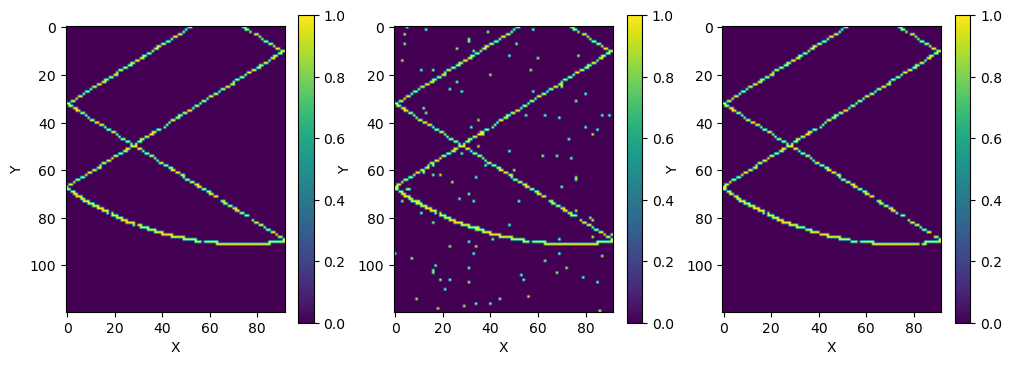

In [396]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
plot2d(test_dataset[0].data)
ax2 = fig.add_subplot(132)
plot2d(test_dataset[0].noised_data)
ax3 = fig.add_subplot(133)
# binary pred, if not 0 then 1
pred_binary = (pred > 0.5).float()
plot2d(pred_binary)

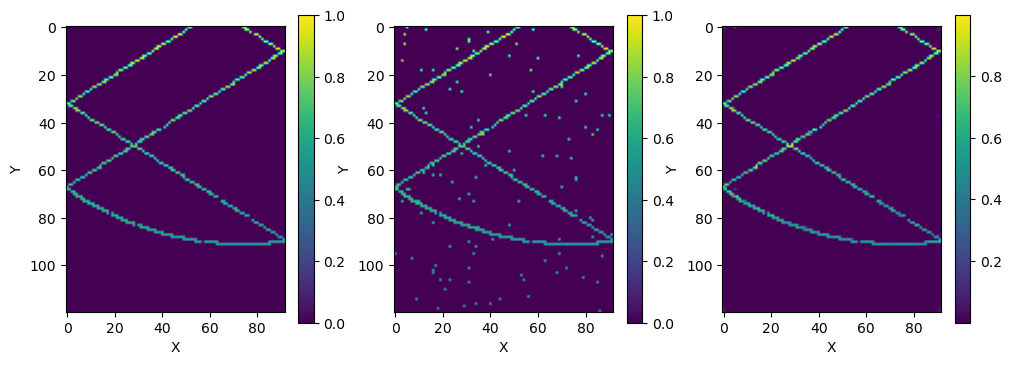

In [397]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
plot2d(test_dataset[0].timed_data / torch.max(test_dataset[0].timed_data))
ax2 = fig.add_subplot(132)
plot2d(test_dataset[0].noised_timed_data / torch.max(test_dataset[0].noised_timed_data))
ax3 = fig.add_subplot(133)
plot2d(pred)

In [398]:
pred_time = torch.where(pred > 0.2, pred, 0) * torch.max(test_dataset[0].noised_timed_data)

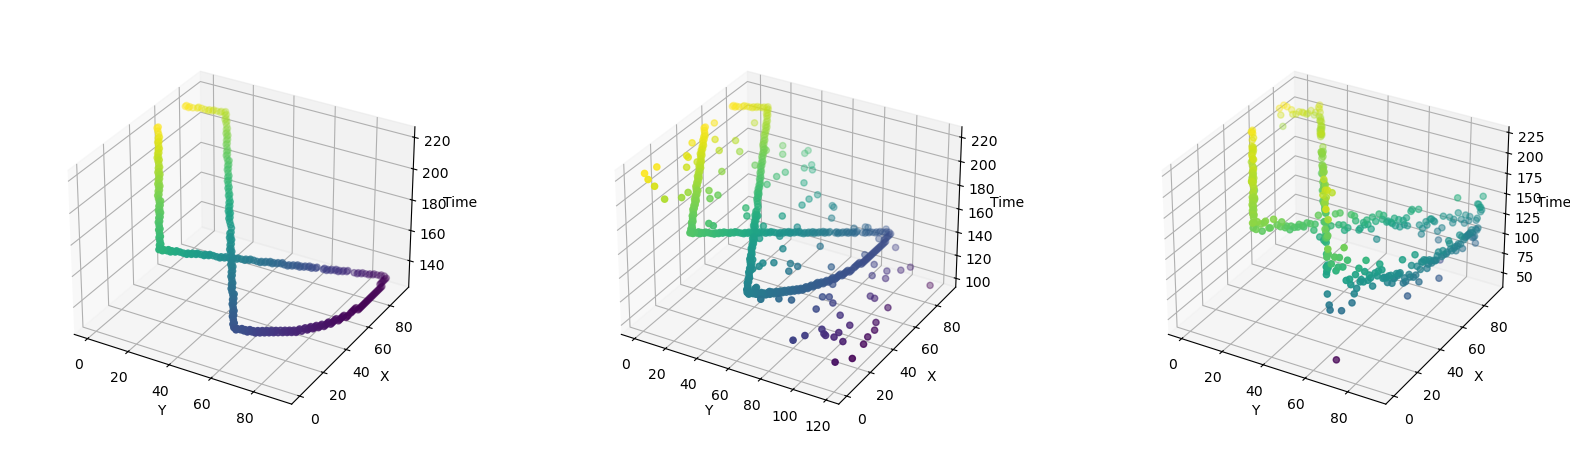

In [399]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(131, projection='3d')
plot3d(test_dataset[0].timed_data, ax1)
ax2 = fig.add_subplot(132, projection='3d')
plot3d(test_dataset[0].noised_timed_data, ax2)
ax3 = fig.add_subplot(133, projection='3d')
plot3d(pred_time, ax3)